# Лабораторная работа №3
Классификация пингвинов
Выполнили студенты Зимин Андрей Валерьевич, Жилин Андрей Игроевич

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import recall_score as rec
from sklearn.metrics import precision_score as pre
from sklearn.model_selection import train_test_split
from matplotlib.ticker import MaxNLocator
import qrcode
import numpy as np
from matplotlib import pyplot as plt
import random
import string
from typing import Callable, List, Union
from numpy.typing import NDArray
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import recall_score as rec
from sklearn.metrics import precision_score as pre
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from matplotlib.ticker import MaxNLocator

## Задание 1
1. Загрузить данные из файла «pinguins.csv». Проверить, что загружены все 333 кортежа данных по всем 7 признакам  
2. Определить типы данных
3. Определить параметры числовых данных
4. Для нечисловых (текстовых) данных определить количество записей по каждому элементу и визуализировать гистограммы, например, так (для признака «species»)
5. Для каждого текстового признака построить мозаику 2D диаграмм рассеяния выбирая в качестве параметров всевозможные пары числовых признаков, аналогично мозаике диаграмм для ирисов.

In [3]:
df = pd.read_csv("./data/penguins.csv")
df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181,3750,male
1,Adelie,Torgersen,39.5,17.4,186,3800,female
2,Adelie,Torgersen,40.3,18.0,195,3250,female
3,Adelie,Torgersen,36.7,19.3,193,3450,female
4,Adelie,Torgersen,39.3,20.6,190,3650,male
...,...,...,...,...,...,...,...
328,Chinstrap,Dream,55.8,19.8,207,4000,male
329,Chinstrap,Dream,43.5,18.1,202,3400,female
330,Chinstrap,Dream,49.6,18.2,193,3775,male
331,Chinstrap,Dream,50.8,19.0,210,4100,male


Загрузили датасет. Действительно 7 признаков и 333 строки

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            333 non-null    object 
 1   island             333 non-null    object 
 2   bill_length_mm     333 non-null    float64
 3   bill_depth_mm      333 non-null    float64
 4   flipper_length_mm  333 non-null    int64  
 5   body_mass_g        333 non-null    int64  
 6   sex                333 non-null    object 
dtypes: float64(2), int64(2), object(3)
memory usage: 18.3+ KB


species            - категориальный признак  
island             - категориальный признак  
bill_length_mm     - числовой признак  
bill_depth_mm      - числовой признак  
flipper_length_mm  - числовой признак  
body_mass_g        - числовой признак  
sex                - бинарный признак   

Перед обучением нужно будет закодировать категориальные признаки one-hot encoding

In [5]:
pd.options.display.float_format = '{:,.3f}'.format
df.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,333.000,333.000,333.000,333.000
mean,43.993,17.165,200.967,"4,207.057"
std,5.469,1.969,14.016,805.216
min,32.100,13.100,172.000,"2,700.000"
25%,39.500,15.600,190.000,"3,550.000"
50%,44.500,17.300,197.000,"4,050.000"
75%,48.600,18.700,213.000,"4,775.000"
max,59.600,21.500,231.000,"6,300.000"


Видим, что сильно выделяется признак массы тела, он на 2-3 порядка больше остальных признаков. Перед обучением было бы неплохо провести нормализацию

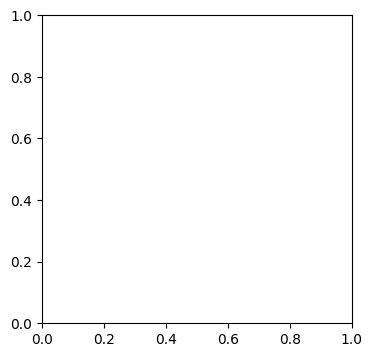

In [6]:
category_columns = ['species', 'island', 'sex']

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
#for i, category in enumerate(category_columns):
#   ax[i].bar()

In [35]:
class Perceptron:
  def __init__(self, hidden_layers : List[int],
               activations: List[Callable],
               eta:Union[int, float] = 1,
               n_epochs: int = 100,
               random_weights=None,
               random_state=None):
    np.random.seed(random_state)
    random.seed(random_state)
    self.is_fitted = False
    self.layers = []
    self.epochs = n_epochs
    self.eta = eta
    self.errors = []
    l = hidden_layers + [1]
    for i in range(len(hidden_layers)):
      self.layers.append(Layer((l[i]+1, l[i+1]), activations[i], i + 1, random_weights=random_weights))

  @staticmethod
  def relu(x):
      return np.maximum(0, x)
  @staticmethod
  def step(x):
      return x >= 0

  @staticmethod
  def shuffle(X, y):
    n = len(y)
    a = [(random.random(), X[i, :], y[i]) for i in range(n)]
    a.sort()
    new_X = np.array([a[i][1] for i in range(n)])
    new_y = np.array([a[i][2] for i in range(n)])
    return new_X, new_y

  def predict(self, train_sample: NDArray, logging: bool = False) -> NDArray:
    result = np.zeros(train_sample.shape[0])
    for i in range(train_sample.shape[0]):
      x = train_sample[i, :]
      for layer in self.layers:
        x = np.append(x, values=[1]) # добавление свободного коэффициента
        x = layer.forward(x, logging)

      result[i] = x[0]
      if logging:
        print(result[i])
    return result

  def train(self, train_sample: NDArray,
            train_ans: NDArray,
            logging=False,
            activation=np.sign,
            random_weights=None) -> list[float]:
    if not self.is_fitted:
        self.layers = [Layer((train_sample.shape[1]+1,
                              self.layers[0].size[0]-1),
                              activation,
                              0,
                              random_weights=random_weights)] + self.layers
        self.is_fitted = True# инициализация сенсоров
    for _ in range(self.epochs):
      train_sample, train_ans = Perceptron.shuffle(train_sample, train_ans)
      error = 0
      for i in range(train_sample.shape[0]):
        x = train_sample[i, :]
        for layer in self.layers:
          x = np.append(x, values=[1]) # добавление свободного коэффициента
          x = layer.forward(x, logging)
        # вычисление ошибки
        ans = x[0]
        delta = train_ans[i] - ans
        error += abs(delta)
        # пересчет весов
        for layer in self.layers:
          layer.backward(self.eta*delta)
      self.errors.append(error)
    return self.errors


class Layer:
  def __init__(self,
               size: tuple[int, int],
               activation: Callable,
               index: int,
               value: Union[int, float]=0,
               random_weights=None):
    self.size = size
    self.w = np.full(size, value)
    if random_weights is not None:
      self.w = np.random.randint(random_weights[0], random_weights[1], self.size)
    self.activation = np.vectorize(activation)
    self.i = index
    self.last_result = np.array([])
    self.last_x = np.array([])

  def backward(self, value) -> None:
    if value > 0:
      # надо увеличить те веса, где нет активации,
      # но должна быть активация
      d = (self.last_x>0)*value
      d = np.repeat(np.array([d]).T, self.w.shape[1], axis=1)
      self.w = self.w + d
    if value < 0:
      # надо уменьшить те веса,
      # где активации быть не должно
      d = (self.last_x>0)*value
      d = np.repeat(np.array([d]).T, self.w.shape[1], axis=1)
      self.w = self.w + d

  def forward(self, x, logging) -> NDArray:
    if logging:
      print(f"Слой №{self.i+1}")
      print(f"Сенсоры  : {x}")
      print(f"Размер: {self.size}")

    m = np.dot(x, self.w)
    result = self.activation(m)
    self.last_result = result
    self.last_x = x
    if logging:
      print(f"Сумматор : {m}")
      print(f"Активация: {result}")
      print(f"Результат размера {result.shape}")

    return result

def count_metrics(predicted : NDArray[bool], real: NDArray[bool], label='') -> None:
    print(f'{label}: ')
    print('Accuracy: ', acc(predicted, real))
    print('Recall: ', rec(predicted, real))
    print('Precision: ', pre(predicted, real))


def get_features(data, target, target_name, features) -> (NDArray, NDArray):

    data = data[features + [target]]
    data.loc[:, target] = (data[target] == target_name)
    data_y = data[[target]].to_numpy().reshape(1, -1)[0] * 1
    data_x = data[features].to_numpy()
    print(X)
    return data_x, data_y


def build_errors(errors: list[float], perceptron: Perceptron) -> None:
    ax = plt.figure().gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.plot(list(range(len(errors))), errors, marker='o', linestyle='dashed')

    plt.xlabel("Эпохи")
    plt.ylabel("Количество ошибок за эпоху")
    plt.title("Обучение нейросети\nбинарной классификации на числовых признаках")
    print("Размерность слоёв: ", *[i.size for i in  perceptron.layers])

In [8]:
def print_contour(model, X, y, main_1=0, main_2=1, supp=None, columns_num=None):
    # 1. Генерируем сетку для 2-х выбранных признаков
    if supp is None:
        supp = [2, 3]
    if columns_num is None:
        columns_num = [''] * 2
    x_min, x_max = X[:, main_1].min() - 1, X[:, main_1].max() + 1
    y_min, y_max = X[:, main_2].min() - 1, X[:, main_2].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

    # 2. Создаём массив точек в 4-х мерном пространстве, но только для выбранных 2-х признаков
    mean_vals = np.mean(X, axis=0)  # Средние значения для всех 4-х признаков
    fixed_features = mean_vals[supp]  # Средние значения для 3-го и 4-го признаков

    grid_points_4d = np.zeros((xx.ravel().shape[0], 2+len(supp)))
    grid_points_4d[:, [main_1, main_2]] = np.column_stack((xx.ravel(), yy.ravel()))  # 2 выбранных признака
    grid_points_4d[:, [supp]] = fixed_features  # Остальные 2 признака - средние значения

    # 3. Предсказываем классы для сеточных точек в 4-х мерном пространстве
    Z = model.predict(grid_points_4d)
    Z = Z.reshape(xx.shape)

    # 4. Визуализация
    plt.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')
    plt.contour(xx, yy, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'], linewidths=[1, 2, 1])

    # Отображаем точки данных
    plt.scatter(X[:, main_1], X[:, main_2], c=y, cmap='coolwarm', edgecolor='k')
    plt.xlabel(columns_num[main_1])
    plt.ylabel(columns_num[main_2])
    plt.title('Проекция линий уровня персептрона на 2D')
    plt.show()



# Задание 2.1

In [9]:
df.species.unique()

array(['Adelie', 'Gentoo', 'Chinstrap'], dtype=object)

In [10]:
numeric_features = ['bill_length_mm', 'bill_depth_mm', 'body_mass_g', 'flipper_length_mm']


In [11]:
X, y = get_features(df, 'sex', 'male', numeric_features)

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=19)


In [12]:
MLP = Perceptron([1000], [Perceptron.step], n_epochs=50, random_state=13)
errors = MLP.train(X_train, y_train , logging=False, activation=Perceptron.step, random_weights=[-100, 100])

Размерность слоёв:  (5, 1000) (1001, 1)


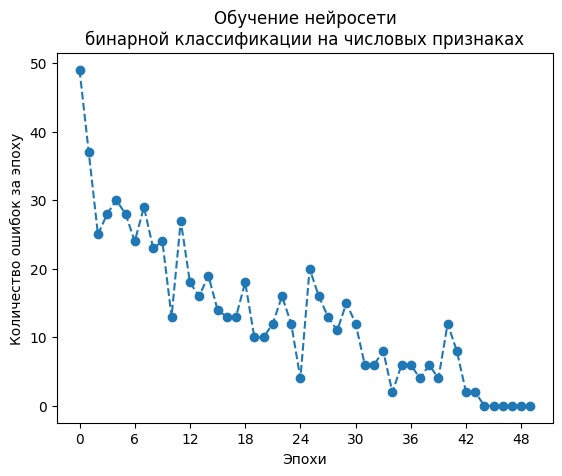

In [13]:
build_errors(errors, MLP)

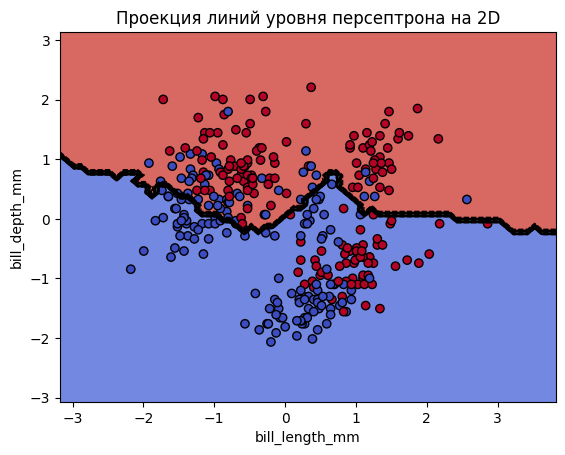

In [14]:
print_contour(MLP, X, y, 0, 1, [2, 3], numeric_features)

In [15]:
y_test_pred = np.array(MLP.predict(X_test)) == 1
y_train_pred = np.array(MLP.predict(X_train)) == 1

count_metrics(y_train_pred, y_train == 1, 'Обучающая выборка')
count_metrics(y_test_pred,  y_test == 1, 'Тестовая выборка')

Обучающая выборка: 
Accuracy:  1.0
Recall:  1.0
Precision:  1.0
Тестовая выборка: 
Accuracy:  0.9
Recall:  0.9111111111111111
Precision:  0.8723404255319149


# Задание 2.2

In [16]:
df[df['species'] == 'Adelie'] #смотрим что там вообще лежит

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.100,18.700,181,3750,male
1,Adelie,Torgersen,39.500,17.400,186,3800,female
2,Adelie,Torgersen,40.300,18.000,195,3250,female
3,Adelie,Torgersen,36.700,19.300,193,3450,female
4,Adelie,Torgersen,39.300,20.600,190,3650,male
...,...,...,...,...,...,...,...
141,Adelie,Dream,36.600,18.400,184,3475,female
142,Adelie,Dream,36.000,17.800,195,3450,female
143,Adelie,Dream,37.800,18.100,193,3750,male
144,Adelie,Dream,36.000,17.100,187,3700,female


In [17]:
def get_features(data, target, target_name, features):

    data = data[features + [target]]
    data.loc[:, target] = (data[target] == target_name)
    data_y = data[[target]].to_numpy().reshape(1, -1)[0] * 1
    data_x = data[numeric_features].to_numpy()

    return data_x, data_y


X1, y1, = get_features(df[df['species'] == 'Adelie'], 'sex', 'male', numeric_features)
X2, y2 = get_features(df[df['species'] == 'Gentoo'], 'sex', 'male', numeric_features)
X3, y3 = get_features(df[df['species'] == 'Chinstrap'], 'sex', 'male', numeric_features)

scaler1 = StandardScaler()
scaler2 = StandardScaler()
scaler3 = StandardScaler()

species = ['Adelie', 'Gentoo', 'Chinstrap']

X1 = scaler1.fit_transform(X1)
X2 = scaler2.fit_transform(X2) # toDo Сделать scaler в одну переменную?
X3 = scaler3.fit_transform(X3)
scalers = [scaler1, scaler2, scaler3]
datas = [X1, X2, X3]
targets = [y1, y2, y3]

In [18]:
percps = []

X_trains = []
X_tests = []
y_trains = []
y_tests = []
for i in range(len(datas)):
    X_local_train, X_local_test, y_local_train, y_local_test = train_test_split(datas[i], targets[i], test_size=0.3, random_state=19)
    percps.append(Perceptron([50], [Perceptron.step], n_epochs=100, random_state=13))
    X_trains.append(X_local_train)
    X_tests.append(X_local_test)
    y_trains.append(y_local_train)
    y_tests.append(y_local_test)
    errors = percps[i].train(X_local_train, y_local_train , logging=False, activation=Perceptron.step, random_weights=[-100, 100])


In [19]:
for i in range(len(datas)):
    y_train_pred = np.array(percps[i].predict(X_trains[i])) == 1
    y_test_pred = np.array(percps[i].predict(X_tests[i])) == 1

    y_train = y_trains[i] == 1
    y_test  = y_tests[i] == 1
    count_metrics(y_train, y_train_pred, f'Обучающая выборка {species[i]}')
    count_metrics(y_test, y_test_pred, f'Тестовая выборка {species[i]}')


Обучающая выборка Adelie: 
Accuracy:  1.0
Recall:  1.0
Precision:  1.0
Тестовая выборка Adelie: 
Accuracy:  0.8636363636363636
Recall:  0.7916666666666666
Precision:  0.95
Обучающая выборка Gentoo: 
Accuracy:  1.0
Recall:  1.0
Precision:  1.0
Тестовая выборка Gentoo: 
Accuracy:  0.9722222222222222
Recall:  1.0
Precision:  0.95
Обучающая выборка Chinstrap: 
Accuracy:  1.0
Recall:  1.0
Precision:  1.0
Тестовая выборка Chinstrap: 
Accuracy:  0.7142857142857143
Recall:  0.7777777777777778
Precision:  0.6363636363636364


Размерность слоёв:  (5, 50) (51, 1)


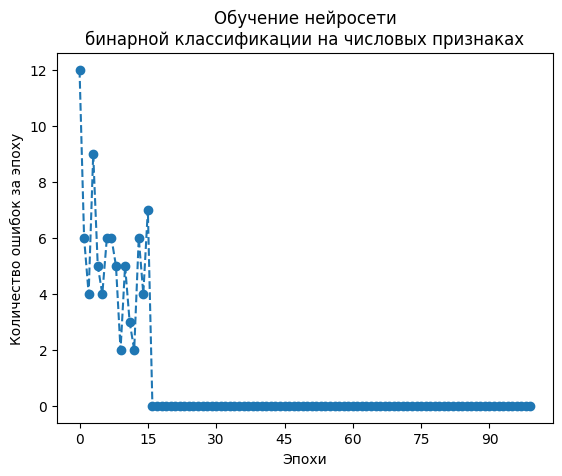

In [20]:
build_errors(errors, percps[-1])

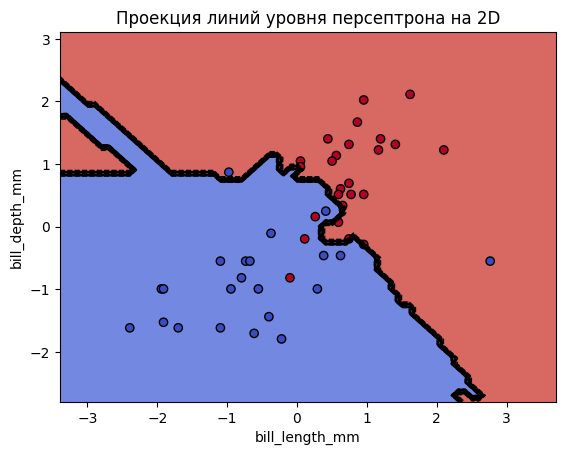

In [21]:
print_contour(percps[-1], X_trains[-1], y_trains[-1], 0, 1, [2, 3], numeric_features)

# Задание 2.3

In [22]:
for i in range(3):
    x_val, y_val = get_features(df, 'sex', 'male', numeric_features)
    x_val = scalers[i].transform(x_val)
    y_val_pred = percps[i].predict(x_val)

    count_metrics(y_val_pred == 1, y_val == 1, 'По всему')

По всему: 
Accuracy:  0.7747747747747747
Recall:  0.6995708154506438
Precision:  0.9702380952380952
По всему: 
Accuracy:  0.7567567567567568
Recall:  0.6746987951807228
Precision:  1.0
По всему: 
Accuracy:  0.8078078078078078
Recall:  0.940677966101695
Precision:  0.6607142857142857


# Задание 3.1

Размерность слоёв:  (5, 1000) (1001, 1)


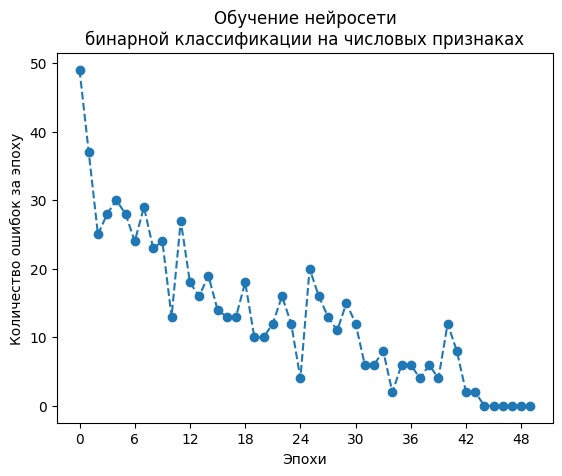

In [23]:


X, y = get_features(df, 'sex', 'male', numeric_features)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=19)

adaline = Perceptron([1000], [Perceptron.step], n_epochs=50, random_state=13)
errors = adaline.train(X_train, y_train, logging=False, activation=Perceptron.step, random_weights=[-100, 100])

build_errors(errors, adaline)


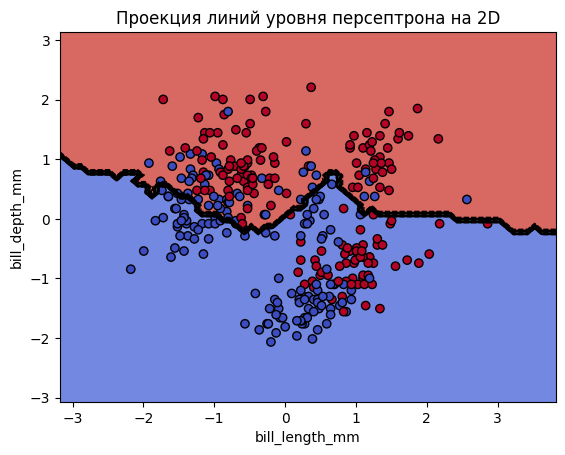

In [24]:
print_contour(adaline, X, y, 0, 1, [2, 3], numeric_features)

# Задание 3.2

In [25]:

copy_df = df.copy()

X1, y1, = get_features(copy_df[copy_df['species'] == 'Adelie'], 'sex', 'male', numeric_features)
X2, y2 = get_features(copy_df[copy_df['species'] == 'Gentoo'], 'sex', 'male', numeric_features)
X3, y3 = get_features(copy_df[copy_df['species'] == 'Chinstrap'], 'sex', 'male', numeric_features)

scaler = StandardScaler()

X1 = scaler.fit_transform(X1)
X2 = scaler.transform(X2)
X3 = scaler.transform(X3)

datas = [X1, X2, X3]
targets = [y1, y2, y3]


X_trains = []
X_tests = []
y_trains = []
y_tests = []
for i in range(len(datas)):
    X_local_train, X_local_test, y_local_train, y_local_test = train_test_split(datas[i], targets[i], test_size=0.3,
                                                                                random_state=19)
    percps.append(Perceptron([50], [Perceptron.step], n_epochs=100, random_state=13))
    X_trains.append(X_local_train)
    X_tests.append(X_local_test)
    y_trains.append(y_local_train)
    y_tests.append(y_local_test)
    errors = adaline.train(X_local_train, y_local_train, logging=False, activation=Perceptron.step,
                             random_weights=[-100, 100])

for i in range(len(datas)):
    y_train_pred = np.array(adaline.predict(X_trains[i])) == 1
    y_test_pred = np.array(adaline.predict(X_tests[i])) == 1

    y_train = y_trains[i] == 1
    y_test = y_tests[i] == 1

    count_metrics(y_train_pred, y_train, 'Обучающая')
    count_metrics(y_test_pred, y_test, 'Тестовая')
X, y = get_features(copy_df, 'sex', 'male', numeric_features)
X = scaler.transform(X)


y_test_pred = adaline.predict(X) == 1
y_test = y == 1
count_metrics(y_test_pred, y_test, 'ALL_X')

Обучающая: 
Accuracy:  0.6470588235294118
Recall:  1.0
Precision:  0.2653061224489796
Тестовая: 
Accuracy:  0.6136363636363636
Recall:  1.0
Precision:  0.2916666666666667
Обучающая: 
Accuracy:  0.8313253012048193
Recall:  1.0
Precision:  0.6666666666666666
Тестовая: 
Accuracy:  0.9444444444444444
Recall:  1.0
Precision:  0.8947368421052632
Обучающая: 
Accuracy:  1.0
Recall:  1.0
Precision:  1.0
Тестовая: 
Accuracy:  0.7619047619047619
Recall:  0.6666666666666666
Precision:  0.8888888888888888
ALL_X: 
Accuracy:  0.7777777777777778
Recall:  0.9607843137254902
Precision:  0.5833333333333334


Размерность слоёв:  (5, 1000) (1001, 1)


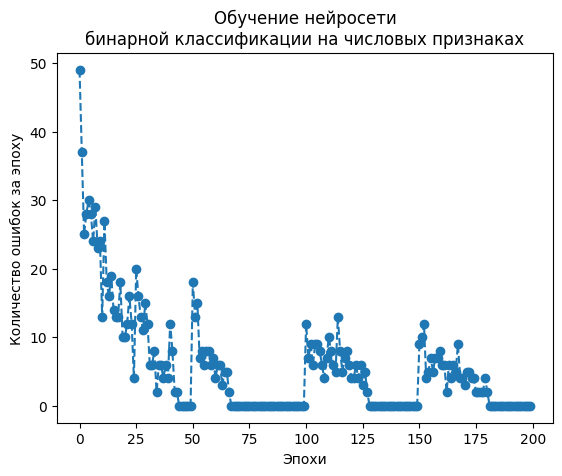

In [26]:
build_errors(errors, adaline)

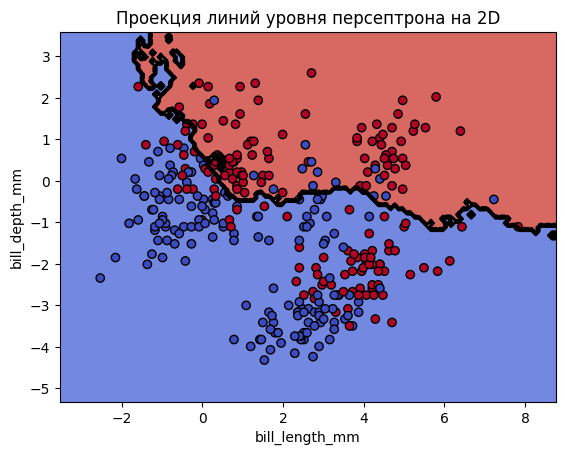

In [27]:
print_contour(adaline, X, y, 0, 1, [2, 3], numeric_features)

In [37]:
adaline_cat = Perceptron([1000], [Perceptron.step], n_epochs=100, random_state=13)
new_features = numeric_features + ['species']
copy_df = df.copy()

labelEncoder = LabelEncoder()
scaler = StandardScaler()
copy_df['species'] = labelEncoder.fit_transform(copy_df['species']) + 1
X, y = get_features(copy_df, 'sex', 'male', numeric_features + ['species'])
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=19)





[[-0.89604189  0.7807321  -0.56847478 -1.42675157 -1.03437424]
 [-0.82278787  0.11958397 -0.50628618 -1.06947358 -1.03437424]
 [-0.67627982  0.42472926 -1.1903608  -0.42637319 -1.03437424]
 ...
 [ 1.02687621  0.52644436 -0.53738048 -0.56928439  0.09126832]
 [ 1.24663828  0.93330475 -0.13315457  0.64546078  0.09126832]
 [ 1.13675725  0.7807321  -0.53738048 -0.2120064   0.09126832]]


In [38]:
errors = adaline_cat.train(X_train, y_train, logging=False, activation=Perceptron.step, random_weights=[-100, 100])

In [39]:
X

array([[-0.89604189,  0.7807321 , -0.56847478, -1.42675157, -1.03437424],
       [-0.82278787,  0.11958397, -0.50628618, -1.06947358, -1.03437424],
       [-0.67627982,  0.42472926, -1.1903608 , -0.42637319, -1.03437424],
       ...,
       [ 1.02687621,  0.52644436, -0.53738048, -0.56928439,  0.09126832],
       [ 1.24663828,  0.93330475, -0.13315457,  0.64546078,  0.09126832],
       [ 1.13675725,  0.7807321 , -0.53738048, -0.2120064 ,  0.09126832]],
      shape=(333, 5))

In [40]:
y_train_pred = np.array(adaline_cat.predict(X_train)) == 1
y_test_pred = np.array(adaline_cat.predict(X_test)) == 1
y_train = y_train == 1
y_test = y_test == 1
count_metrics(y_train_pred, y_train, 'Обучающая выборка')
count_metrics(y_test_pred, y_test, 'Тестовая выборка')

Обучающая выборка: 
Accuracy:  1.0
Recall:  1.0
Precision:  1.0
Тестовая выборка: 
Accuracy:  0.85
Recall:  0.9
Precision:  0.7659574468085106


Размерность слоёв:  (6, 1000) (1001, 1)


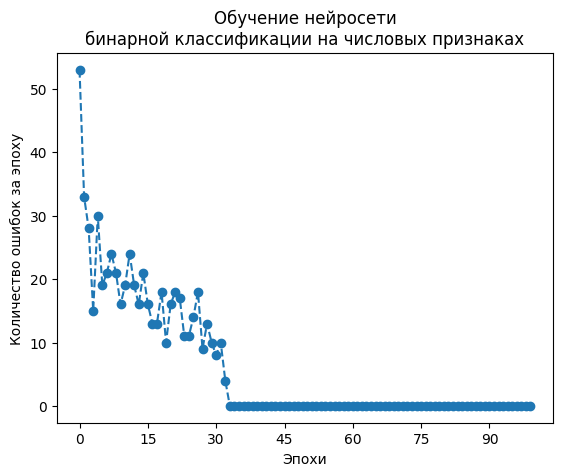

In [41]:

build_errors(errors, adaline_cat)



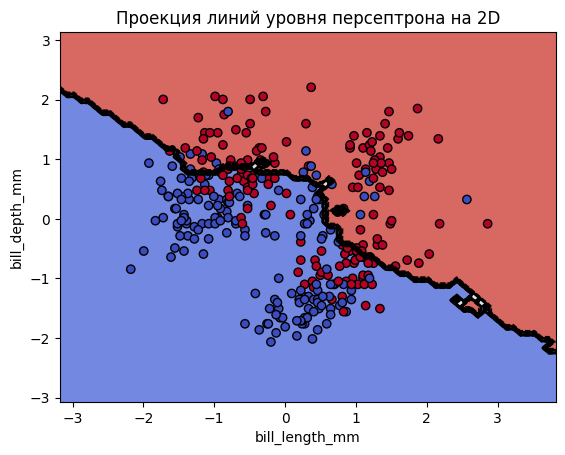

In [42]:
print_contour(adaline_cat, X, y, 0, 1, [2, 3, 4], new_features)

# Задание 3.3

In [43]:
adaline_one_hot = Perceptron([1000], [Perceptron.step], n_epochs=100, random_state=13)
new_features = numeric_features + ['species']


ohe = OneHotEncoder(sparse_output=False)
ohe.set_output(transform='pandas')
copy_df = df.copy()


df_species = ohe.fit_transform(df[['species']].to_numpy())

copy_df = pd.concat([copy_df[numeric_features], df_species], axis=1)
copy_df




,bill_length_mm,bill_depth_mm,body_mass_g,flipper_length_mm,x0_Adelie,x0_Chinstrap,x0_Gentoo
0,39.100,18.700,3750,181,1.000,0.000,0.000
1,39.500,17.400,3800,186,1.000,0.000,0.000
2,40.300,18.000,3250,195,1.000,0.000,0.000
3,36.700,19.300,3450,193,1.000,0.000,0.000
4,39.300,20.600,3650,190,1.000,0.000,0.000
...,...,...,...,...,...,...,...
328,55.800,19.800,4000,207,0.000,1.000,0.000
329,43.500,18.100,3400,202,0.000,1.000,0.000
330,49.600,18.200,3775,193,0.000,1.000,0.000
331,50.800,19.000,4100,210,0.000,1.000,0.000


In [44]:
temp_df = pd.concat([copy_df, df[['sex']]], axis=1)


In [45]:

X, y = get_features( temp_df, 'sex', 'male', numeric_features + list(ohe.get_feature_names_out()))
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=19)


[[-0.89604189  0.7807321  -0.56847478 -1.42675157 -1.03437424]
 [-0.82278787  0.11958397 -0.50628618 -1.06947358 -1.03437424]
 [-0.67627982  0.42472926 -1.1903608  -0.42637319 -1.03437424]
 ...
 [ 1.02687621  0.52644436 -0.53738048 -0.56928439  0.09126832]
 [ 1.24663828  0.93330475 -0.13315457  0.64546078  0.09126832]
 [ 1.13675725  0.7807321  -0.53738048 -0.2120064   0.09126832]]


In [46]:
errors = adaline_one_hot.train(X_train, y_train, logging=False, activation=Perceptron.step, random_weights=[-100, 100])
y_train_pred = np.array(adaline_one_hot.predict(X_train)) == 1
y_test_pred = np.array(adaline_one_hot.predict(X_test)) == 1
y_train = y_train == 1
y_test = y_test == 1
count_metrics(y_train_pred, y_train, 'Обучающая выборка')
count_metrics(y_test_pred, y_test, 'Тестовая выборка')

Обучающая выборка: 
Accuracy:  1.0
Recall:  1.0
Precision:  1.0
Тестовая выборка: 
Accuracy:  0.91
Recall:  0.9130434782608695
Precision:  0.8936170212765957


Размерность слоёв:  (8, 1000) (1001, 1)


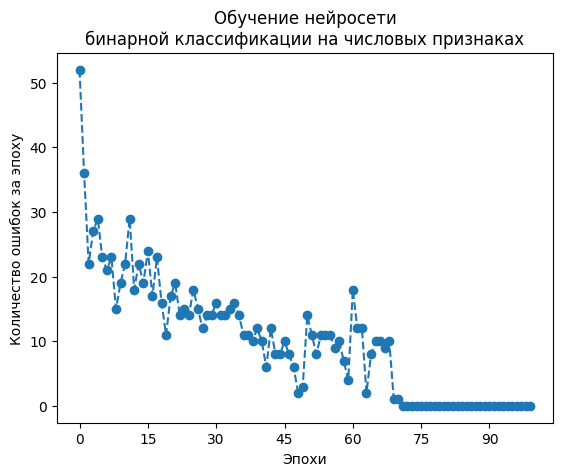

In [47]:
build_errors(errors, adaline_one_hot)

#

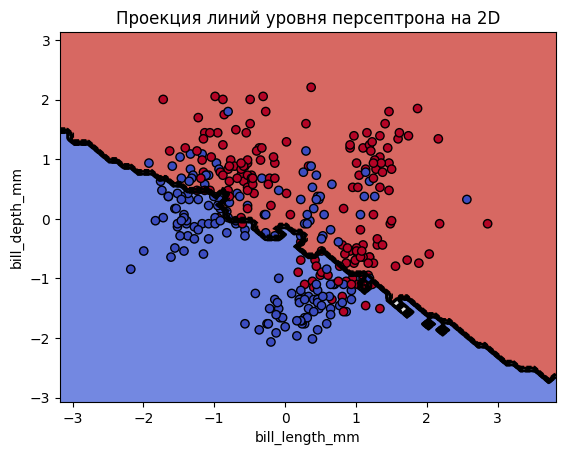

In [48]:
print_contour(adaline_one_hot, X, y, 0, 1, [2, 3, 4, 5, 6], new_features)

# Задание 3.4

In [66]:
copy_df['sex'] = (df['sex'] == 'male').apply(float)

In [67]:
copy_df

,bill_length_mm,bill_depth_mm,body_mass_g,flipper_length_mm,x0_Adelie,x0_Chinstrap,x0_Gentoo,sex
0,39.100,18.700,3750,181,1.000,0.000,0.000,1.000
1,39.500,17.400,3800,186,1.000,0.000,0.000,0.000
2,40.300,18.000,3250,195,1.000,0.000,0.000,0.000
3,36.700,19.300,3450,193,1.000,0.000,0.000,0.000
4,39.300,20.600,3650,190,1.000,0.000,0.000,1.000
...,...,...,...,...,...,...,...,...
328,55.800,19.800,4000,207,0.000,1.000,0.000,1.000
329,43.500,18.100,3400,202,0.000,1.000,0.000,0.000
330,49.600,18.200,3775,193,0.000,1.000,0.000,1.000
331,50.800,19.000,4100,210,0.000,1.000,0.000,1.000


In [ ]:
X_adelie, y_adelie = get_features(copy_df, 'x0_Adelie', True, numeric_features + ['sex'])
X_chinstrap, y_chinstrap = get_features(copy_df, 'x0_Chinstrap', True, numeric_features + ['sex'])
X_gentoo, y_gentoo = get_features(copy_df, 'x0_Gentoo', True, numeric_features + ['sex'])
scaler = StandardScaler()
X_adelie = scaler.fit_transform(X_adelie)
X_chinstrap = scaler.transform(X_chinstrap)
X_gentoo = scaler.transform(X_gentoo)

In [78]:
X_adelie

array([[-0.89604189,  0.7807321 , -0.56847478, -1.42675157,  0.99103121],
       [-0.82278787,  0.11958397, -0.50628618, -1.06947358, -1.00904996],
       [-0.67627982,  0.42472926, -1.1903608 , -0.42637319, -1.00904996],
       ...,
       [ 1.02687621,  0.52644436, -0.53738048, -0.56928439,  0.99103121],
       [ 1.24663828,  0.93330475, -0.13315457,  0.64546078,  0.99103121],
       [ 1.13675725,  0.7807321 , -0.53738048, -0.2120064 , -1.00904996]],
      shape=(333, 5))

In [74]:
X_penguins = [X_adelie, X_chinstrap, X_gentoo]
y_penguins = [y_adelie, y_chinstrap, y_gentoo]
X_trains = []
X_tests = []
y_trains = []
y_tests = []
percps_pen = []
for i in range(len(datas)):
    X_local_train, X_local_test, y_local_train, y_local_test = train_test_split(X_penguins[i], y_penguins[i], test_size=0.3,
                                                                                random_state=19)
    percps_pen.append(Perceptron([50], [Perceptron.step], n_epochs=100, random_state=13))
    X_trains.append(X_local_train)
    X_tests.append(X_local_test)
    y_trains.append(y_local_train)
    y_tests.append(y_local_test)
    errors = percps_pen[i].train(X_local_train, y_local_train, logging=False, activation=Perceptron.step,
                             random_weights=[-100, 100])

for i in range(len(datas)):
    y_train_pred = np.array(percps_pen[i].predict(X_trains[i])) == 1
    y_test_pred = np.array(percps_pen[i].predict(X_tests[i])) == 1

    y_train = y_trains[i] == 1
    y_test = y_tests[i] == 1

    count_metrics(y_train_pred, y_train, 'Обучающая')
    count_metrics(y_test_pred, y_test, 'Тестовая')



Обучающая: 
Accuracy:  1.0
Recall:  1.0
Precision:  1.0
Тестовая: 
Accuracy:  1.0
Recall:  1.0
Precision:  1.0
Обучающая: 
Accuracy:  1.0
Recall:  1.0
Precision:  1.0
Тестовая: 
Accuracy:  1.0
Recall:  1.0
Precision:  1.0
Обучающая: 
Accuracy:  1.0
Recall:  1.0
Precision:  1.0
Тестовая: 
Accuracy:  1.0
Recall:  1.0
Precision:  1.0


Размерность слоёв:  (6, 50) (51, 1)


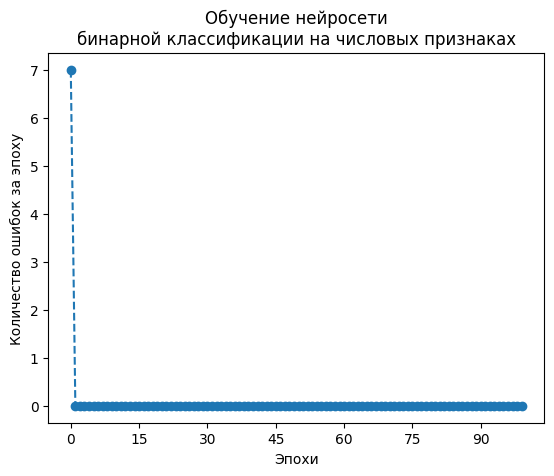

In [75]:
build_errors(errors, percps_pen[0])

Размерность слоёв:  (6, 50) (51, 1)


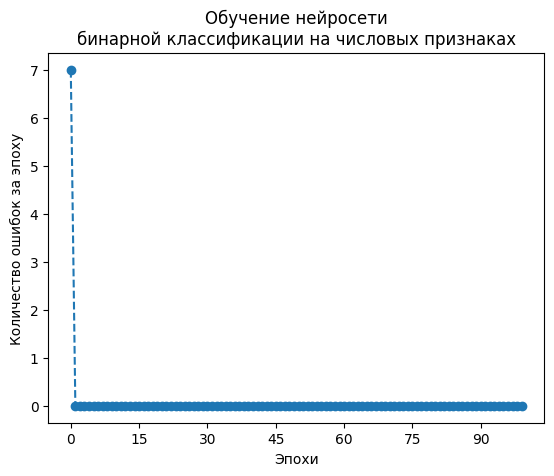

In [76]:
build_errors(errors, percps_pen[1])

Размерность слоёв:  (6, 50) (51, 1)


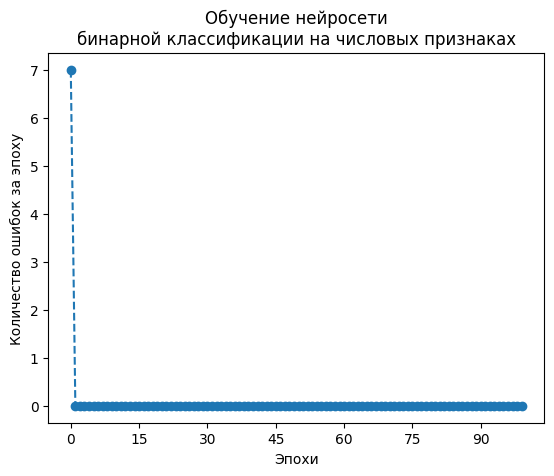

In [77]:
build_errors(errors, percps_pen[2])

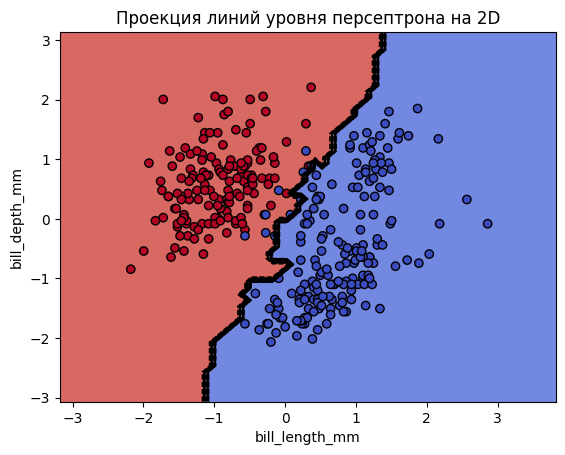

In [79]:
print_contour(percps_pen[0], X_penguins[0], y_penguins[0], 0, 1, [2, 3, 4], new_features)

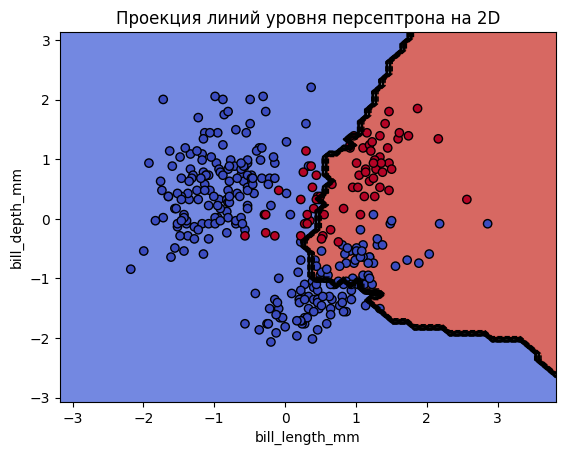

In [80]:
print_contour(percps_pen[1], X_penguins[1], y_penguins[1], 0, 1, [2, 3, 4], new_features)

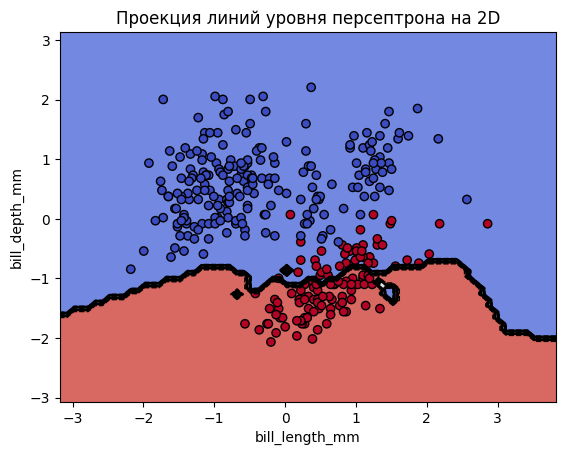

In [81]:
print_contour(percps_pen[2], X_penguins[2], y_penguins[2], 0, 1, [2, 3, 4], new_features)

# Задание 3.5

In [82]:
ohe_islands = OneHotEncoder(sparse_output=False)
ohe.set_output(transform='pandas')
df_islands = ohe.fit_transform(df[['island']].to_numpy())

copy_df = pd.concat([copy_df, df_islands], axis=1)
copy_df


,bill_length_mm,bill_depth_mm,body_mass_g,flipper_length_mm,x0_Adelie,x0_Chinstrap,x0_Gentoo,sex,x0_Biscoe,x0_Dream,x0_Torgersen
0,39.100,18.700,3750,181,1.000,0.000,0.000,1.000,0.000,0.000,1.000
1,39.500,17.400,3800,186,1.000,0.000,0.000,0.000,0.000,0.000,1.000
2,40.300,18.000,3250,195,1.000,0.000,0.000,0.000,0.000,0.000,1.000
3,36.700,19.300,3450,193,1.000,0.000,0.000,0.000,0.000,0.000,1.000
4,39.300,20.600,3650,190,1.000,0.000,0.000,1.000,0.000,0.000,1.000
...,...,...,...,...,...,...,...,...,...,...,...
328,55.800,19.800,4000,207,0.000,1.000,0.000,1.000,0.000,1.000,0.000
329,43.500,18.100,3400,202,0.000,1.000,0.000,0.000,0.000,1.000,0.000
330,49.600,18.200,3775,193,0.000,1.000,0.000,1.000,0.000,1.000,0.000
331,50.800,19.000,4100,210,0.000,1.000,0.000,1.000,0.000,1.000,0.000


In [ ]:
X_adelie, y_adelie = get_features(copy_df, 'x0_Adelie', True, numeric_features + ['sex'] + ['x0_Biscoe', 'x0_Dream', 'x0_Torgersen'])
X_chinstrap, y_chinstrap = get_features(copy_df, 'x0_Chinstrap', True, numeric_features + ['sex'] + ['x0_Biscoe', 'x0_Dream', 'x0_Torgersen'])
X_gentoo, y_gentoo = get_features(copy_df, 'x0_Gentoo', True, numeric_features + ['sex'] + ['x0_Biscoe', 'x0_Dream', 'x0_Torgersen'])
scaler = StandardScaler()
X_adelie = scaler.fit_transform(X_adelie)
X_chinstrap = scaler.transform(X_chinstrap)
X_gentoo = scaler.transform(X_gentoo)

In [84]:
X_adelie

array([[-0.89604189,  0.7807321 , -0.56847478, ..., -0.97919535,
        -0.76531973,  2.46680084],
       [-0.82278787,  0.11958397, -0.50628618, ..., -0.97919535,
        -0.76531973,  2.46680084],
       [-0.67627982,  0.42472926, -1.1903608 , ..., -0.97919535,
        -0.76531973,  2.46680084],
       ...,
       [ 1.02687621,  0.52644436, -0.53738048, ..., -0.97919535,
         1.30664344, -0.40538335],
       [ 1.24663828,  0.93330475, -0.13315457, ..., -0.97919535,
         1.30664344, -0.40538335],
       [ 1.13675725,  0.7807321 , -0.53738048, ..., -0.97919535,
         1.30664344, -0.40538335]], shape=(333, 8))

In [85]:
X_penguins = [X_adelie, X_chinstrap, X_gentoo]
y_penguins = [y_adelie, y_chinstrap, y_gentoo]
X_trains = []
X_tests = []
y_trains = []
y_tests = []
percps_pen = []
for i in range(len(datas)):
    X_local_train, X_local_test, y_local_train, y_local_test = train_test_split(X_penguins[i], y_penguins[i], test_size=0.3,
                                                                                random_state=19)
    percps_pen.append(Perceptron([50], [Perceptron.step], n_epochs=100, random_state=13))
    X_trains.append(X_local_train)
    X_tests.append(X_local_test)
    y_trains.append(y_local_train)
    y_tests.append(y_local_test)
    errors = percps_pen[i].train(X_local_train, y_local_train, logging=False, activation=Perceptron.step,
                             random_weights=[-100, 100])

for i in range(len(datas)):
    y_train_pred = np.array(percps_pen[i].predict(X_trains[i])) == 1
    y_test_pred = np.array(percps_pen[i].predict(X_tests[i])) == 1

    y_train = y_trains[i] == 1
    y_test = y_tests[i] == 1

    count_metrics(y_train_pred, y_train, 'Обучающая')
    count_metrics(y_test_pred, y_test, 'Тестовая')

Обучающая: 
Accuracy:  1.0
Recall:  1.0
Precision:  1.0
Тестовая: 
Accuracy:  0.99
Recall:  1.0
Precision:  0.9791666666666666
Обучающая: 
Accuracy:  1.0
Recall:  1.0
Precision:  1.0
Тестовая: 
Accuracy:  0.99
Recall:  0.9375
Precision:  1.0
Обучающая: 
Accuracy:  1.0
Recall:  1.0
Precision:  1.0
Тестовая: 
Accuracy:  1.0
Recall:  1.0
Precision:  1.0


Размерность слоёв:  (9, 50) (51, 1)


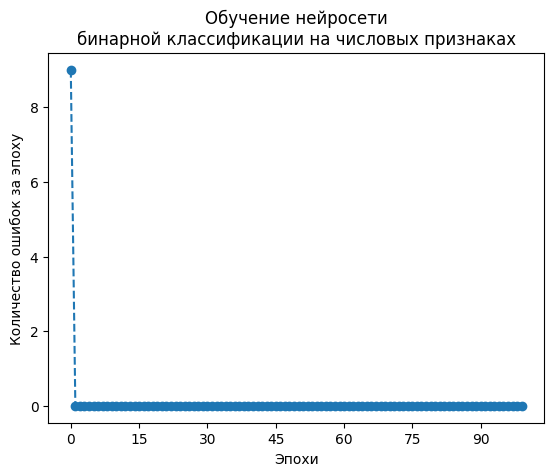

In [86]:
build_errors(errors, percps_pen[0])

Размерность слоёв:  (9, 50) (51, 1)


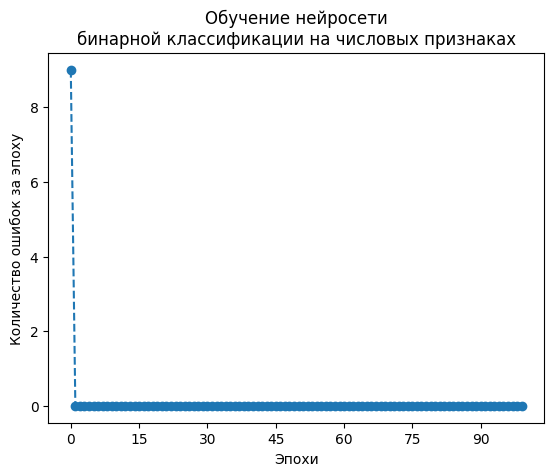

In [87]:
build_errors(errors, percps_pen[1])

Размерность слоёв:  (9, 50) (51, 1)


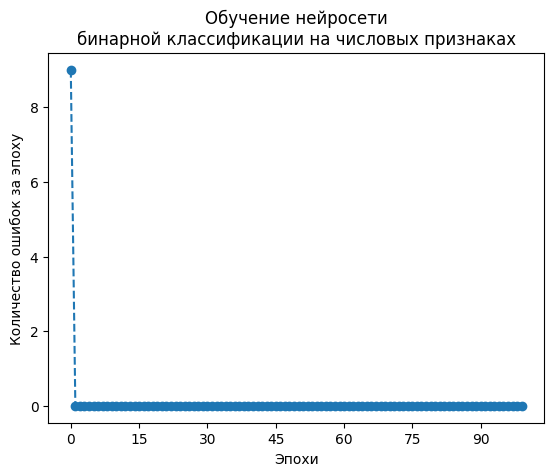

In [88]:
build_errors(errors, percps_pen[2])

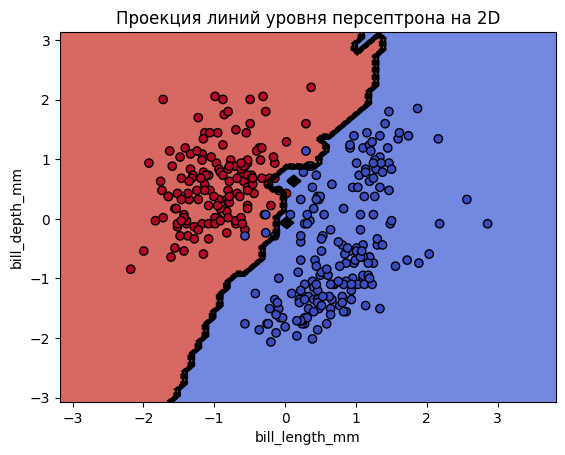

In [91]:
print_contour(percps_pen[0], X_penguins[0], y_penguins[0], 0, 1, [2, 3, 4, 5, 6, 7], new_features)

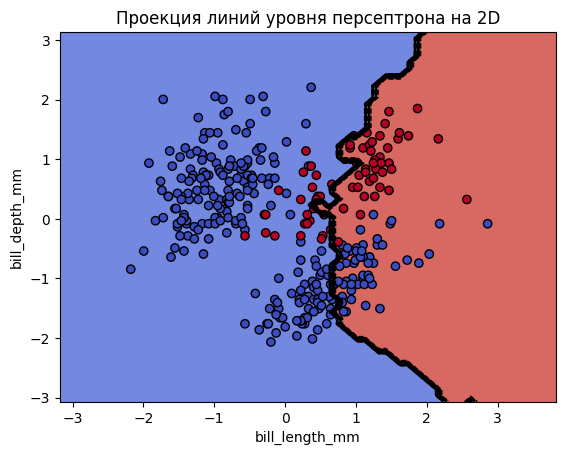

In [92]:
print_contour(percps_pen[1], X_penguins[1], y_penguins[1], 0, 1, [2, 3, 4, 5, 6, 7], new_features)

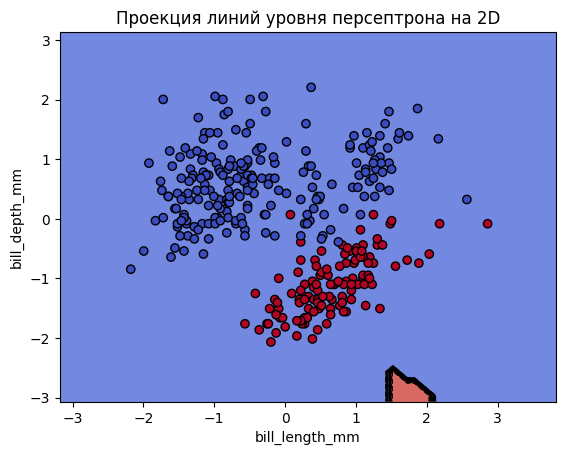

In [94]:
print_contour(percps_pen[2], X_penguins[2], y_penguins[2], 0, 1, [2, 3, 4,5, 6, 7], new_features)

In [ ]:
copy_df = df.copy()

new_features = numeric_features + ['species']
copy_df = df.copy()

labelEncoder = LabelEncoder()
scaler = StandardScaler()
copy_df['sex'] = (copy_df['sex'] == 'male').apply(float)
copy_df['species'] = labelEncoder.fit_transform(copy_df['species']) + 1
X, _ = get_features(copy_df, 'species', 'Adelie', numeric_features + ['sex'])
y = copy_df['species'].to_numpy().reshape(1, -1)[0] * 1
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=19)


X = get_features()

In [144]:
y = y - 2

In [158]:
MLP_targ = Perceptron([500], [Perceptron.step, lambda x: x], n_epochs=500, random_state=13)
errors = MLP_targ.train(X_train, y_train, logging=False, activation= lambda x: x,
                             random_weights=[-1000, 1000])


Размерность слоёв:  (6, 500) (501, 1)


(1.0, 2000.0)

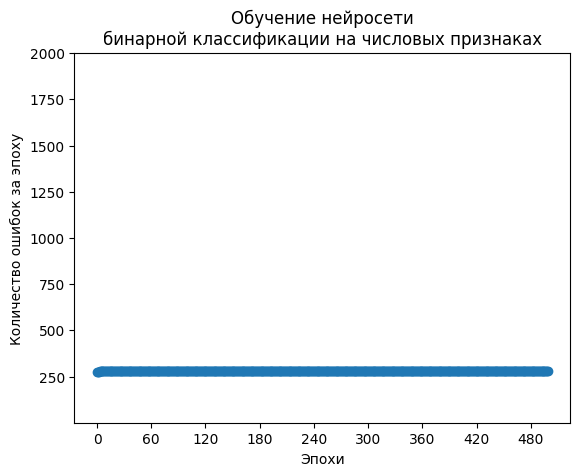

In [159]:
build_errors(errors, MLP_targ)
plt.ylim((1, 2000))

In [157]:
MLP_targ.predict(X_train)

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [148]:
MLP_targ.layers[2].activation.pyfunc.__name__

'<lambda>'